In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 256#512
nSimTime = 256*100#2048
nTime = nLat+1
lSim = 0
nSims = 10#00

phi0 = 1.
lenLat = 100.;
phi_initial = 0
nCols = 2

nyq = nLat//2; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)

dx, dk, spec  0.390625 0.06283185307179587 128
dtout/dt =  0.9961089494163424
light_cone =  0


### Theoretical Field PS 

In [4]:
# field spectrum
# prediction from lattice renormalization

norm = lambda phi: 1./ phi / np.sqrt(lenLat)
freqs1 = dk * np.asarray(np.arange(-nLat/2,1).tolist() + np.arange(1,nLat/2).tolist()) 
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
freqs2 = np.fft.fftshift(np.fft.fftfreq(nLat))*nLat
omega = lambda m2: np.sqrt(freqs**2. + m2)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, m2, tem: norm(phi) * np.sqrt(2./(np.exp(omega(m2)/tem) - 1.)) / np.sqrt(2.*omega(m2))
pspec = lambda phi, m2, tem, sigma: np.abs(spectral_field(phi, m2, tem) * Filter(sigma))**2.
sigma0_th = lambda phi, m2, tem, sigma: np.sqrt(np.sum(pspec(phi, m2, tem, sigma)))

V = lambda x, m2, lam, gam: (- 0.5 * m2 * x**2. + lam * x**4. / 24. - gam * x) if gam == 0.25 else (- 0.5 * m2 * x**2. + lam * x**4. / 24. - gam * x**3. / 6. if x < 0. else - 0.5 * m2 * x**2. + lam * x**4. / 24.) if gam == 0.5 else (- 0.5 * m2 * x**2. + lam * x**4. / 24.) if gam == 0. else (0.5 * m2 * x**2. + lam * x**4. / 24.)
VVVV = lambda lam: lam

deltam2 = lambda phi, lam, m2, tem, sigma: 0.5 * VVVV(lam) * sigma0_th(phi, m2, tem, sigma)**2.

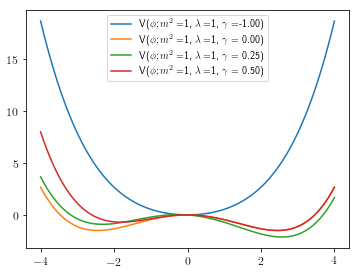

In [5]:
xlist = np.linspace(-4, 4, 100)
m2eff = 1.
lamb = 1.
plt.figure()
[plt.plot(xlist, [V(x, m2eff, lamb, gam) for x in xlist], label=f'V($\phi; m^2 = $%1.f, $\lambda = $%1.f, $\gamma = $%5.2f)'%(m2eff, lamb, gam)) for gam in [-1, 0, 0.25, 0.5]]
plt.legend(); plt.show()

In [6]:
max(freqs)

7.979645340118075

### Extract data from files

In [7]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, m2, gam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)

In [8]:
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))
list_thresh = lambda tem, sigma: np.arange(1, 500)/100*sigma0_th(tem, sigma)

def extract_sim(nT, nL, tem, phi, lam, m2, gam, sim, sigma=0.):
    data = np.genfromtxt(sim_location((nSimTime if gam >= 0. else nT-1), nL, tem, phi, lam, m2, gam, sim))
#    print(tem, phi, lam, m2, gam, sim)
    simulation = [[]]*nCols
    for col in range(nCols):
        simulation[col] = np.reshape(data[:,col], ((nT if gam >= 0. else nT-1), nL))
    if sigma != 0:
        for col in range(nCols):
            simulation[col] = np.asarray([smoothen(slic, sigma) for slic in simulation[col]])
    return np.asarray(simulation)[:, -nL:, :]

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [9]:
m2eff = 1.
lamb = 1.
list_gamma = [-1., 0., 0.25, 0.5]
list_temp = (np.arange(1, 5)/10).tolist() + (np.arange(5, 81, 5)/10.).tolist(); print(list_temp)

filter_size = 0.

[0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]


In [10]:
all_data = np.asarray([[[extract_sim(nTime, nLat, temp, phi0, lamb, m2eff, gamma, sim, filter_size) for sim in range(lSim, nSims)] for gamma in list_gamma] for temp in list_temp])

In [11]:
np.shape(all_data[0])

(4, 10, 2, 256, 256)

In [12]:
#for sim in range(0, nSims-lSim, nSims-lSim):
#    fig, ax = plt.subplots(len(list_temp), len(list_gamma)+1, figsize = (4*len(list_gamma)+4, 4*len(list_temp)+4))
#    for temp in range(len(list_temp)):
#        for gamma in range(len(list_gamma)):
#            im0 = ax[temp][gamma].imshow(all_data[temp][gamma][sim][0], aspect='auto', interpolation='none', origin='lower')
#            clb = plt.colorbar(im0, ax = ax[temp][gamma])
#            ax[temp][gamma].set_title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
#    plt.suptitle('Simulation '+str(sim))
#    plt.show()

[128.  64.  32.  16.   8.   4.   2.   1.]


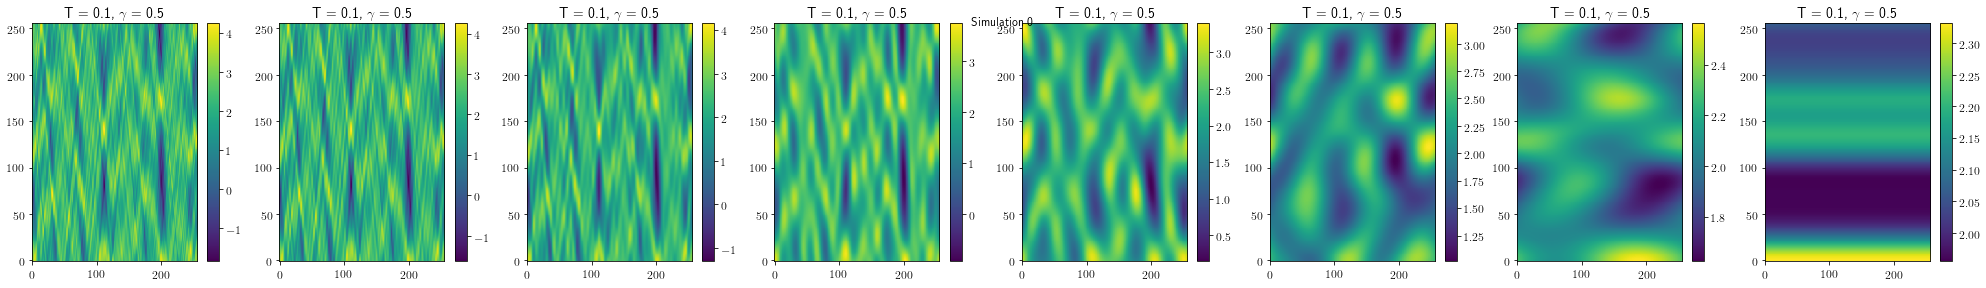

In [13]:
kcut_list = 2.**np.arange(0, 8, 1)[::-1]; print(kcut_list)

gamma = -1
temp = 0

for sim in range(0, nSims, nSims):
    fig, ax = plt.subplots(1, len(kcut_list), figsize = (4*len(kcut_list)+4, 4))
    for kcut in range(len(kcut_list)):
        ensemble = [np.fft.ifft([np.fft.fft(all_data[temp][gamma][sim][0][timeslice])[i] if (i < kcut_list[kcut] or i > nLat-kcut_list[kcut]) else 0. for i in range(nLat)]) for timeslice in range(nTime-1)]
        im0 = ax[kcut].imshow(np.real(ensemble), aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[kcut])
        ax[kcut].set_title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
    plt.suptitle('Simulation '+str(sim))
    plt.show()

In [14]:
from scipy.ndimage import gaussian_filter1d

In [15]:
#print(np.shape(all_data)) # (temperatures, potential, simulations, columns, time, space)

#fld_var = lambda filter, temp, gamma, timeslice: np.mean([np.var(gaussian_filter1d(all_data[temp][gamma][sim][0][timeslice], sigma=filter)) for sim in range(nSims-lSim)])
#mom_var = lambda filter, temp, gamma, timeslice: np.mean([np.var(gaussian_filter1d(all_data[temp][gamma][sim][1][timeslice], sigma=filter)) for sim in range(nSims-lSim)])

#fld_mean = lambda filter, temp, gamma, timeslice: np.mean([np.mean(gaussian_filter1d(all_data[temp][gamma][sim][0][timeslice], sigma=filter)) for sim in range(nSims-lSim)])
#mom_mean = lambda filter, temp, gamma, timeslice: np.mean([np.mean(gaussian_filter1d(all_data[temp][gamma][sim][1][timeslice], sigma=filter)) for sim in range(nSims-lSim)])

# this cuts high frequencies
fld_var = lambda kcut, temp, gamma, timeslice: np.mean([np.var(np.fft.ifft([np.fft.fft(all_data[temp][gamma][sim][0][timeslice])[i] if (i < kcut or i > nLat-kcut) else 0. for i in range(nLat)])) for sim in range(nSims-lSim)])
mom_var = lambda kcut, temp, gamma, timeslice: np.mean([np.var(np.fft.ifft([np.fft.fft(all_data[temp][gamma][sim][1][timeslice])[i] if (i < kcut or i > nLat-kcut) else 0. for i in range(nLat)])) for sim in range(nSims-lSim)])

fld_mean = lambda kcut, temp, gamma, timeslice: np.mean([np.mean(np.fft.ifft([np.fft.fft(all_data[temp][gamma][sim][0][timeslice])[i] if (i < kcut or i > nLat-kcut) else 0. for i in range(nLat)])) for sim in range(nSims-lSim)])
mom_mean = lambda kcut, temp, gamma, timeslice: np.mean([np.mean(np.fft.ifft([np.fft.fft(all_data[temp][gamma][sim][1][timeslice])[i] if (i < kcut or i > nLat-kcut) else 0. for i in range(nLat)])) for sim in range(nSims-lSim)])

In [16]:
##pspec evolution in time of one mode for all temperatures
time_list = np.arange(nTime-1)
##filter_list = np.arange(1, nLat//4+1, nLat//32); print(filter_list)
#kcut_list = 2.**np.arange(0, 8, 1)[::-1]; print(kcut_list)

#for temp in [0, -1]:
#    for gamma in range(len(list_gamma)):
#        fig, ax = plt.subplots(1, 2, figsize=(13, 4))
#        for kcut in kcut_list:
#            ax[0].plot(time_list, [fld_var(kcut, temp, gamma, timeslice) for timeslice in time_list], label='kcut = '+str(kcut))
#        for kcut in kcut_list:
#            ax[1].plot(time_list, [fld_mean(kcut, temp, gamma, timeslice) for timeslice in time_list], label='kcut = '+str(kcut))
#            ax[1].axhline(np.mean([fld_mean(kcut, temp, gamma, timeslice) for timeslice in time_list]), color='darkgray', ls='--')
#        [i.set_xlabel('time') for i in ax]
#        [i.legend() for i in ax]
#        ax[0].set_ylabel('field variance')
#        ax[1].set_ylabel('field mean')
#        plt.title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
#        plt.show()

In [17]:
#fft_field = np.asarray([[[[np.fft.fftshift(np.fft.fft(all_data[temp][gamma][sim][0][timeslice]))/nLat for sim in range(nSims-lSim)] for timeslice in range(nTime)] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])
#fft_momentum = np.asarray([[[[np.fft.fftshift(np.fft.fft(all_data[temp][gamma][sim][1][timeslice]))/nLat for sim in range(nSims-lSim)] for timeslice in range(nTime)] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])

#pspec_field = np.abs(fft_field)**2.
#pspec_momentum = np.abs(fft_momentum)**2.

#matrix = np.asarray([[[[[np.abs(np.mean(fft_field[temp,gamma,timeslice], axis=0))**2., np.mean(fft_field[temp,gamma,timeslice]*np.conj(fft_momentum[temp,gamma,timeslice]), axis=0)],[np.mean(fft_momentum[temp,gamma,timeslice]*np.conj(fft_field[temp,gamma,timeslice]), axis=0), np.abs(np.mean(fft_momentum[temp,gamma,timeslice], axis=0))**2.]] for timeslice in range(nTime)] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])
#det_matrix = np.asarray([[[[np.linalg.det(matrix[temp,gamma,timeslice, :, :, kmode]) for kmode in range(len(fft_field[0,0,0,0]))] for timeslice in range(nTime)] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])

In [18]:
pspec_field = np.asarray([[[np.mean([np.abs(np.fft.fftshift(np.fft.fft(all_data[temp][gamma][sim][0][timeslice])))**2./nLat**2. for sim in range(nSims-lSim)], axis=0) for timeslice in time_list] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])
pspec_momentum = np.asarray([[[np.mean([np.abs(np.fft.fftshift(np.fft.fft(all_data[temp][gamma][sim][1][timeslice])))**2./nLat**2. for sim in range(nSims-lSim)], axis=0) for timeslice in time_list] for gamma in range(len(list_gamma))] for temp in range(len(list_temp))])


(20, 4, 256, 256)


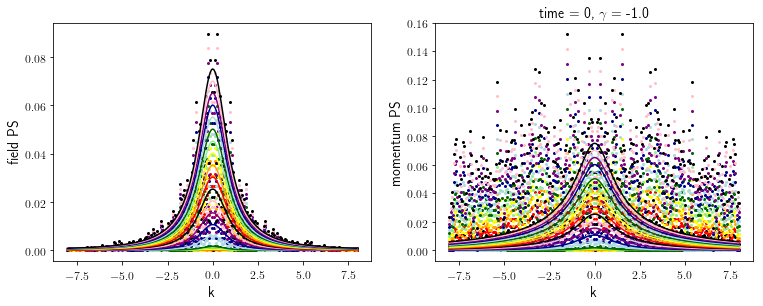

In [19]:
print(np.shape(pspec_field)) # (temperatures, potential, time, simulation, mode)

cols = ['red', 'orange', 'yellow', 'lightgreen', 'darkgreen', 'lightblue', 'darkblue', 'purple', 'pink', 'black']
cols = cols + cols + cols
timeslice = 0
gamma = 0

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
[i.set_xlabel('k') for i in ax]
ax[0].set_ylabel('field PS')
ax[1].set_ylabel('momentum PS')
[ax[0].plot(freqs, pspec_field[temp,gamma,timeslice], color = cols[temp], marker='o', linestyle='None', ms=2, label='T='+str(list_temp[temp])) for temp in range(len(list_temp))]
[ax[0].plot(freqs, pspec(phi0, m2eff, list_temp[temp], 0.), color = cols[temp]) for temp in range(len(pspec_field))]
[ax[1].plot(freqs, pspec_momentum[temp,gamma,timeslice], color = cols[temp], marker='o', linestyle='None', ms=2, label='T='+str(list_temp[temp])) for temp in range(len(list_temp))]
[ax[1].plot(freqs, omega(m2eff)*pspec(phi0, m2eff, list_temp[temp], 0.), color = cols[temp]) for temp in range(len(pspec_momentum))]
plt.title('time = '+str(timeslice)+f', $\gamma$ = '+str(list_gamma[gamma]))
plt.show()

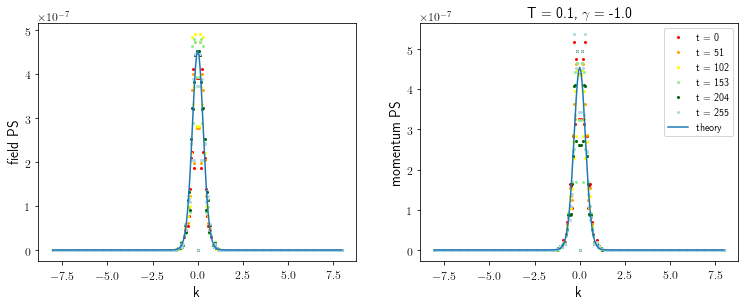

In [20]:
#field pspec simulations vs theory at different times
temp = 0
gamma = 0
time_list = np.arange(0, nTime, nTime//5).tolist()

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
[i.set_xlabel('k') for i in ax]
ax[0].set_ylabel('field PS')
ax[1].set_ylabel('momentum PS')

[ax[0].plot(freqs, pspec_field[temp,gamma,timeslice], color = cols[time_list.index(timeslice)], marker='o', linestyle='None', ms=2, label='t = '+str(timeslice)) for timeslice in time_list]
ax[0].plot(freqs, pspec(phi0, m2eff, list_temp[temp], 0.), label='theory')

[ax[1].plot(freqs, pspec_momentum[temp,gamma,timeslice], color = cols[time_list.index(timeslice)], marker='o', linestyle='None', ms=2, label='t = '+str(timeslice)) for timeslice in time_list]
ax[1].plot(freqs, omega(m2eff)*pspec(phi0, m2eff, list_temp[temp], 0.), label='theory')

plt.title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
plt.legend(); plt.show()

In [33]:
# get mass best fit
omega_fit = lambda k, a, m: a*k + m

multiplier = 2
def get_masses_per_sim(kcut, gam):
    masses = np.asarray([[[0.]]*all_data.shape[2]]*all_data.shape[0])
    for temp in range(len(list_temp)):
        for sim in range(nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            T, N = simulation.shape
            simulation = [np.fft.ifft([np.fft.fft(simulation[timeslice])[i] if (i < kcut or i > N-kcut) else 0. for i in range(N)]) for timeslice in range(T)]
            simulation = simulation - np.mean(simulation)

            kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
            oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
            #k = np.fft.fftshift(np.fft.fftfreq(N))*N
            #o = np.fft.fftshift(np.fft.fftfreq(T))*T

            pspec_sim = np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2./N**2./T**2.
            #pspec_sim[T//2, :]= 0.
            #pspec_sim[:, N//2] = 0.
            maxVal = np.mean(pspec_sim) + multiplier * np.std(pspec_sim)
            osccoords = np.argwhere(pspec_sim > maxVal)

            try:
                popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)
                masses[temp][sim] = popt[-1]
                if masses[temp][sim] < 0: masses[temp][sim] = 'nan'
            except TypeError:
                masses[temp][sim] = 'nan'
                continue

            if sim == 0.1 and temp == len(list_temp)-1:
                lim = 5
                plt.figure()
                im = plt.imshow(pspec_sim>maxVal, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                plt.plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=2, label='freqs')
                plt.plot(kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2., 'o', ms=2, label='freqs sq')
                plt.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label='m=%5.5f'%np.sqrt(popt[-1]))
                plt.plot(kk, omega_fit(kk**2.,*popt), label=f'$m^2=$%5.5f'%popt[-1])
                plt.ylim(0,lim); plt.xlim(-lim,lim)
                plt.axhline(np.sqrt(popt[-1]), color='darkgray', ls='-.')
                plt.axhline(popt[-1], color='darkgray', ls='-.')
                plt.legend(); plt.show()

                fig, ax = plt.subplots(1, 1, figsize = (8, 4))
                ax.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
                im = ax.imshow(pspec_sim, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                clb = plt.colorbar(im, ax = ax)
                ax.set_title('Sim '+str(sim)+': T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
                plt.xlabel(r'$\bar{k}$')
                plt.ylabel(r'$\bar{\omega_k}$')
                plt.ylim(-2*lim,2*lim); plt.xlim(-2*lim,2*lim)
                plt.axvline(0, color='darkgray', ls='-.')
                plt.axhline(0, color='darkgray', ls='-.')
                plt.legend(); plt.show()
    return masses

multiplier = 1
def get_masses(kcut, gam):
    PSPECS = [[]]*all_data.shape[0]
    masses = [[]]*all_data.shape[0]
    for temp in range(len(list_temp)):
        for sim in range(nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            T, N = simulation.shape
            simulation = [np.fft.ifft([np.fft.fft(simulation[timeslice])[i] if (i < kcut or i > N-kcut) else 0. for i in range(N)]) for timeslice in range(T)]
            simulation = simulation - np.mean(simulation)
            PSPECS[temp].append(np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2./N**2./T**2.)
        PSPECS[temp] = np.mean(PSPECS[temp], axis = 0)
        PSPECS[temp] = PSPECS[temp]

        T, N = PSPECS[temp].shape
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
            
        #maxVal = np.mean(PSPECS[temp]) + multiplier * np.std(PSPECS[temp])
        #osccoords = np.argwhere(PSPECS[temp] > maxVal)
        osccoords = np.argwhere(PSPECS[temp] > 0)

        #popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)
        #masses[temp] = popt[-1]
        #if masses[temp] < 0: masses[temp] = 'nan'

        if True:
            lim = 5
            if False:
                plt.figure()
                im = plt.imshow(PSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                plt.plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=2, label='freqs')
                plt.plot(kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2., 'o', ms=2, label='freqs sq')
                #plt.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label='m=%5.5f'%np.sqrt(popt[-1]))
                plt.plot(kk, omega_fit(kk**2.,*popt), label=f'$m^2=$%5.5f'%popt[-1])
                plt.ylim(0,lim); plt.xlim(-lim,lim)
                plt.axhline(np.sqrt(popt[-1]), color='darkgray', ls='-.')
                plt.axhline(popt[-1], color='darkgray', ls='-.')
                plt.legend(); plt.show()

            fig, ax = plt.subplots(1, 1, figsize = (8, 4))
            #ax.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
            im = ax.imshow(PSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax)
            ax.set_title('T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            plt.xlabel(r'$\bar{k}$')
            plt.ylabel(r'$\bar{\omega_k}$')
            plt.ylim(-2*lim,2*lim); plt.xlim(-2*lim,2*lim)
            plt.axvline(0, color='darkgray', ls='-.')
            plt.axhline(0, color='darkgray', ls='-.')
            plt.legend(); plt.show()
    return masses

[128.  64.  32.  16.]
2.0


No handles with labels found to put in legend.


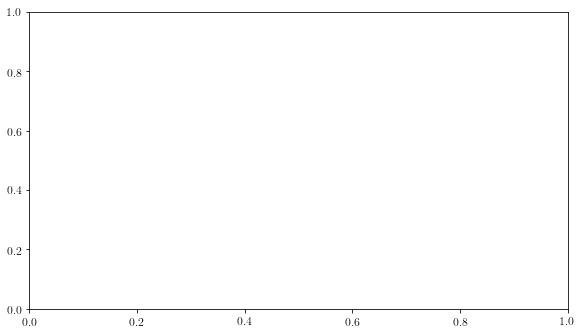

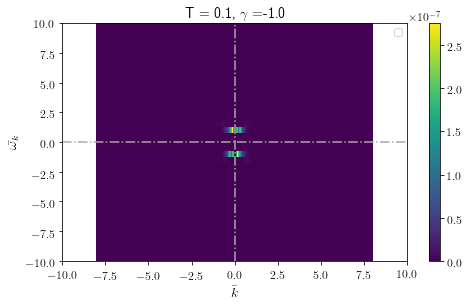

No handles with labels found to put in legend.


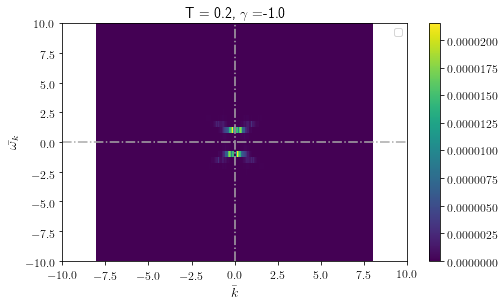

No handles with labels found to put in legend.


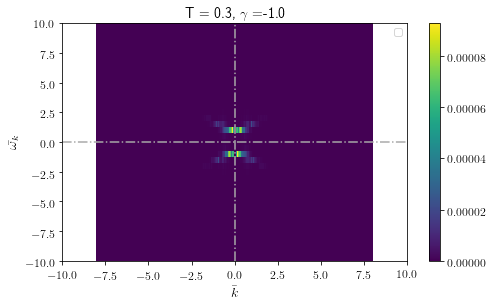

No handles with labels found to put in legend.


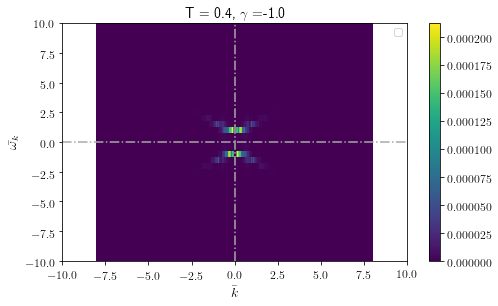

No handles with labels found to put in legend.


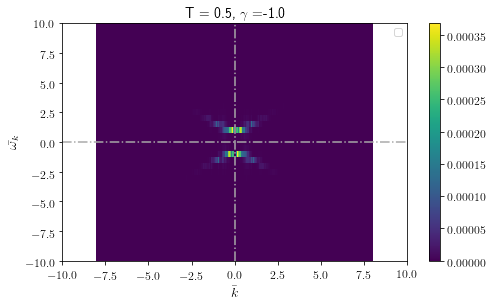

No handles with labels found to put in legend.


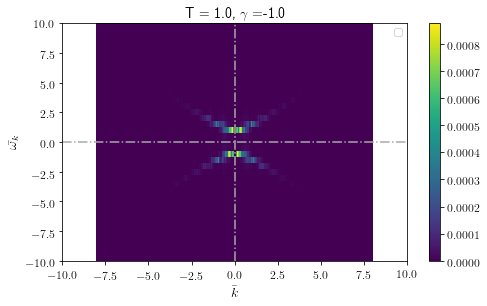

No handles with labels found to put in legend.


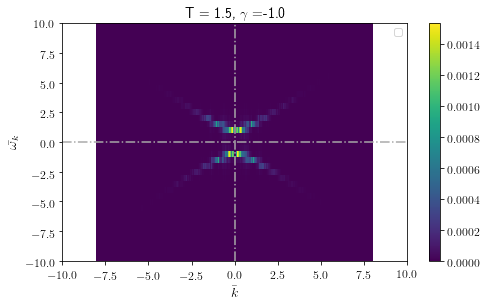

No handles with labels found to put in legend.


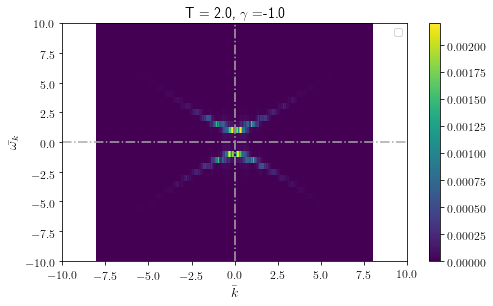

No handles with labels found to put in legend.


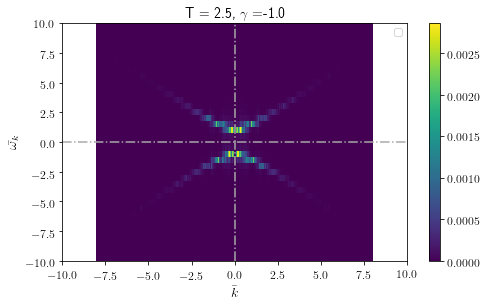

No handles with labels found to put in legend.


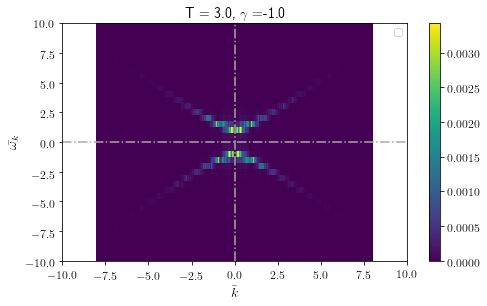

No handles with labels found to put in legend.


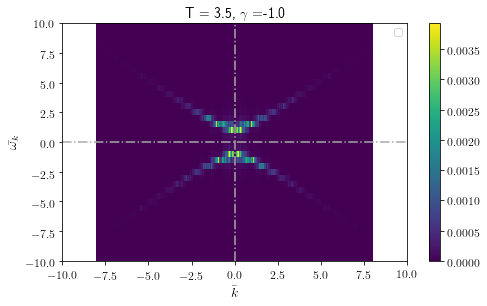

No handles with labels found to put in legend.


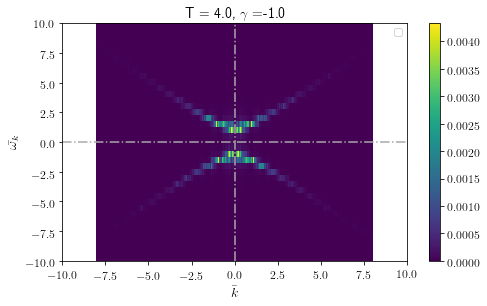

No handles with labels found to put in legend.


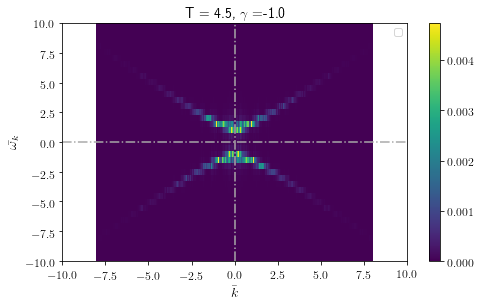

No handles with labels found to put in legend.


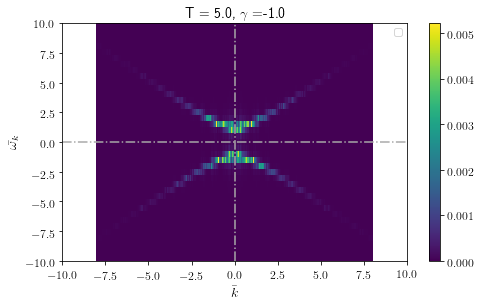

No handles with labels found to put in legend.


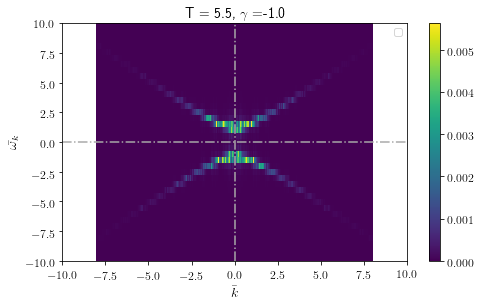

No handles with labels found to put in legend.


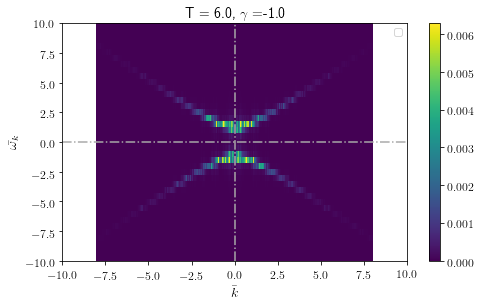

No handles with labels found to put in legend.


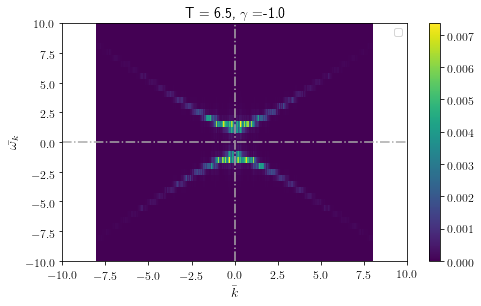

No handles with labels found to put in legend.


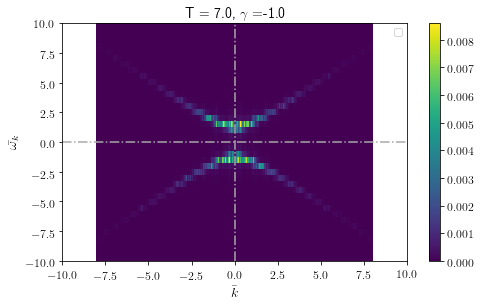

No handles with labels found to put in legend.


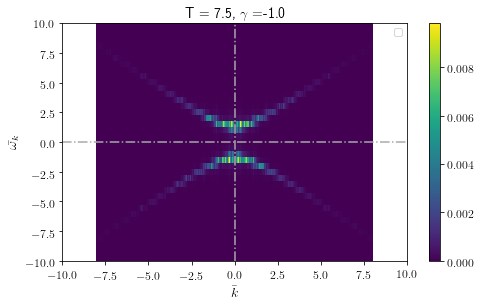

No handles with labels found to put in legend.


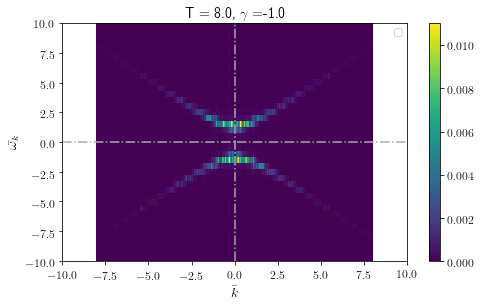

ZeroDivisionError: integer division or modulo by zero

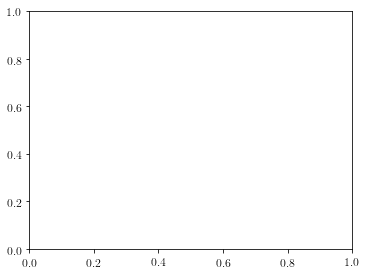

In [34]:
fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)
kcut_list = 2.**np.arange(4, 8, 1)[::-1]; print(kcut_list)

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))

mu2 = 2*m2eff; print(mu2)
mthermal2 = lambda tem: (lamb/24.) * tem**2.


gam = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for kcut in kcut_list[::]:
    masses = get_masses(kcut, gam)
#    mean_masses = np.ndarray.flatten(np.nanmean(masses, axis=1))
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=next(colors), label=f'$k_cut$ = '+str(kcut))

th_masses = np.asarray([m2eff + deltam2(phi0, lamb, m2eff, tem, 0.) for tem in fine_temp_list])
plt.plot(fine_temp_list, np.abs(th_masses), color=next(colors), label='corrected potential mass')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()

128.0


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


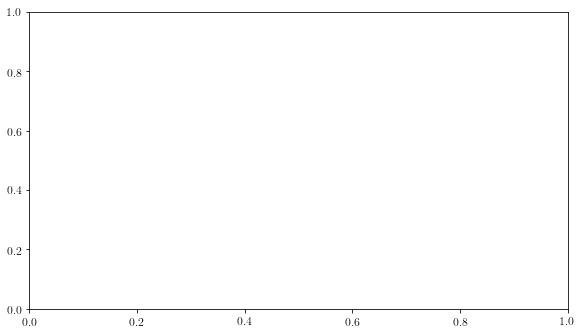

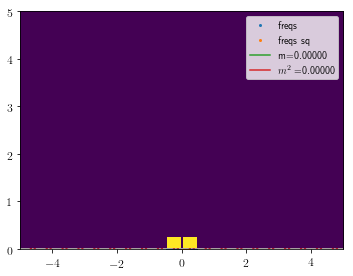

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in sqrt


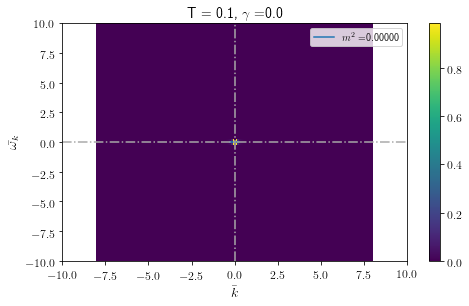

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt


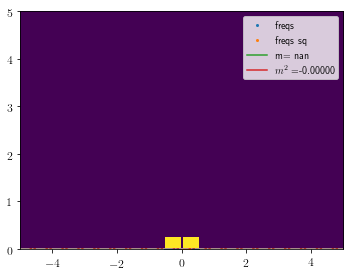

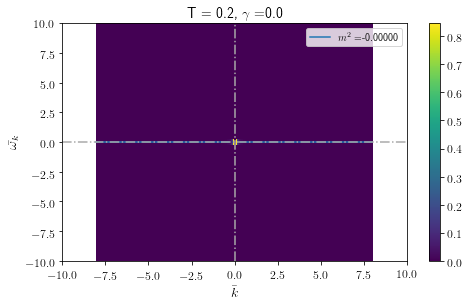

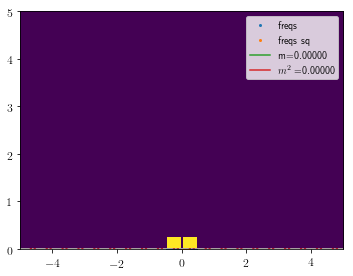

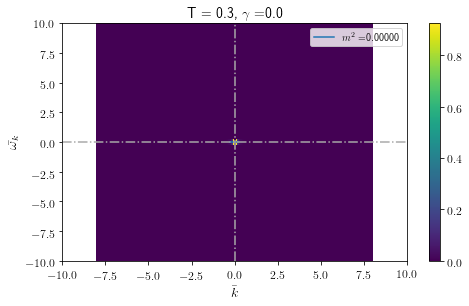

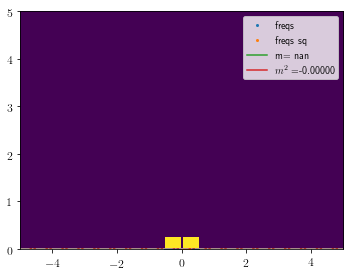

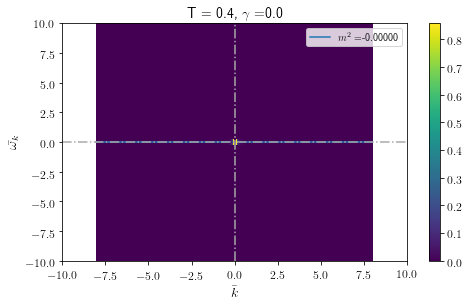

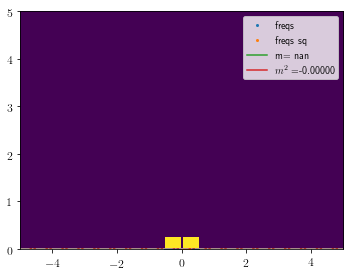

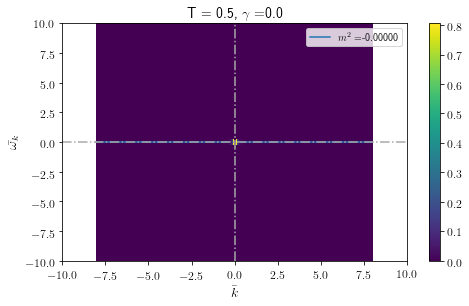

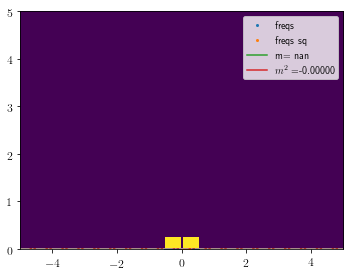

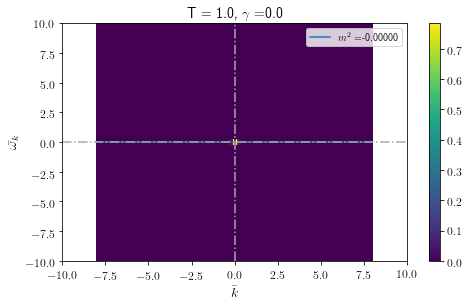

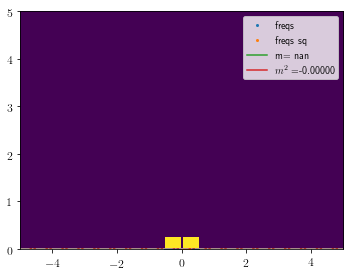

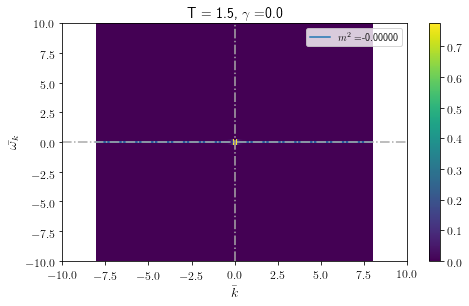

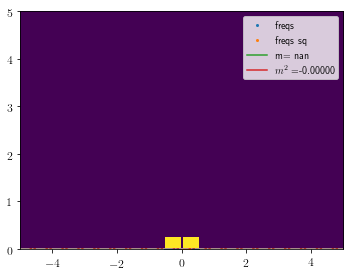

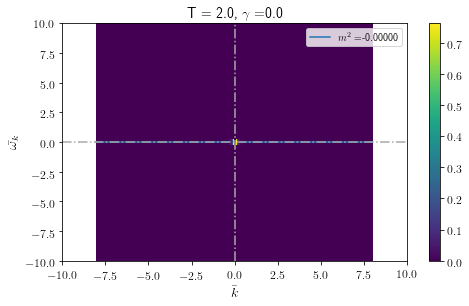

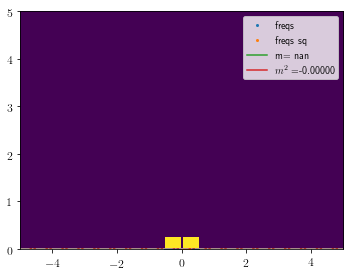

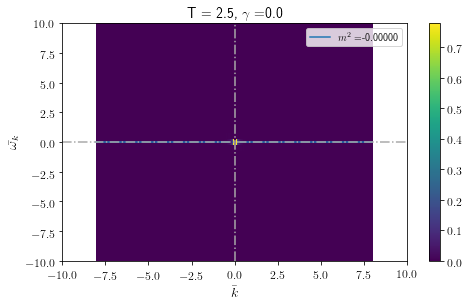

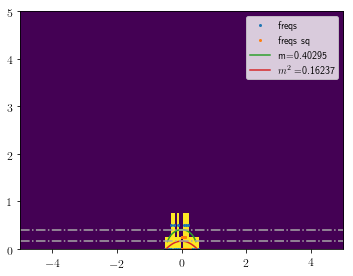

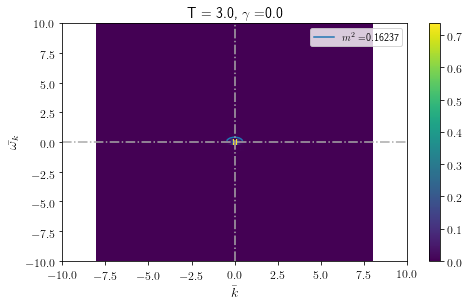

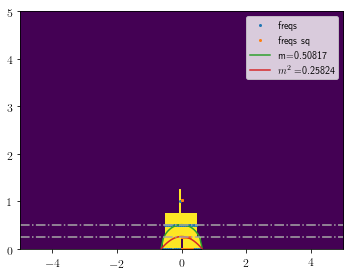

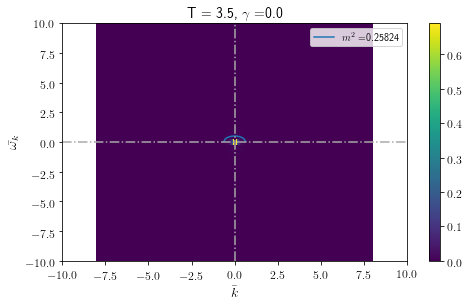

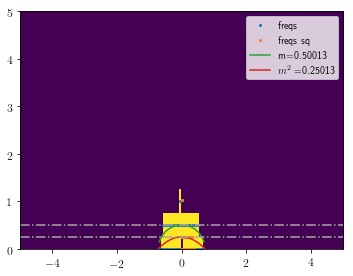

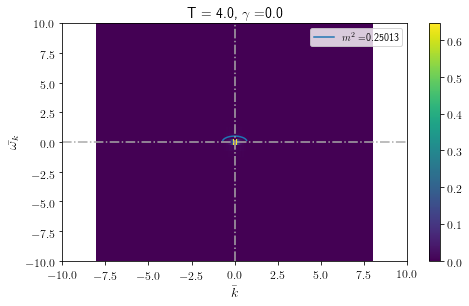

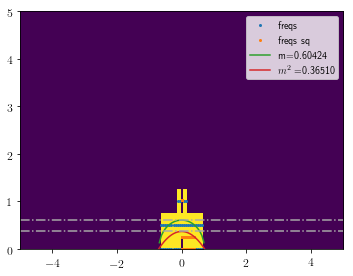

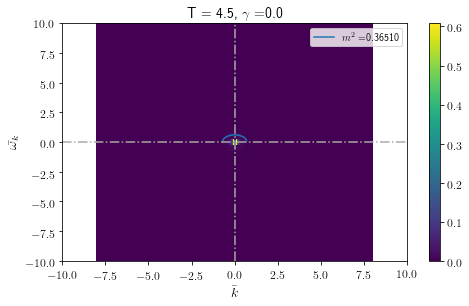

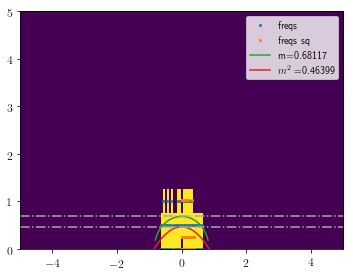

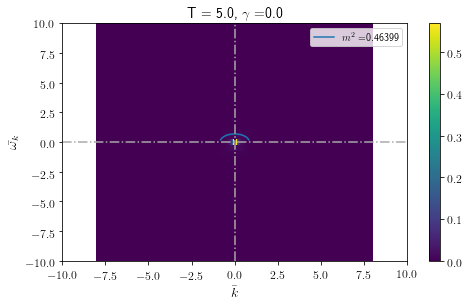

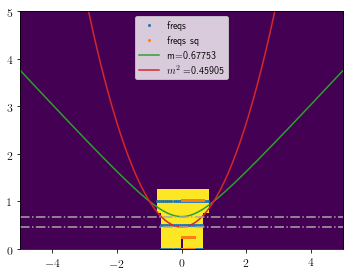

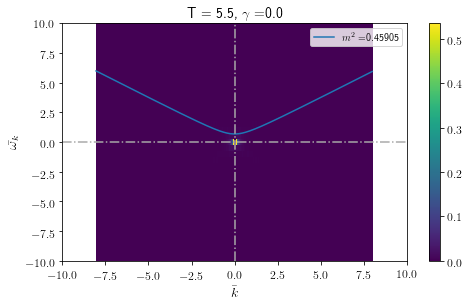

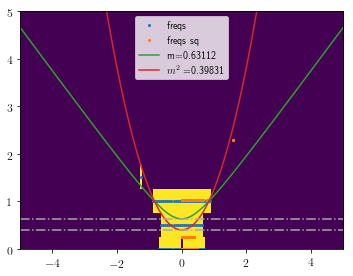

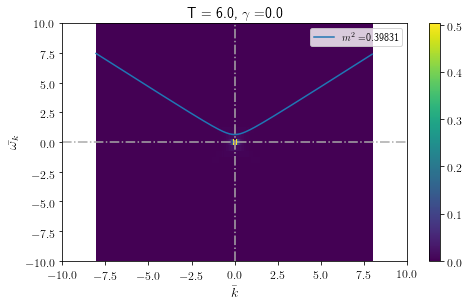

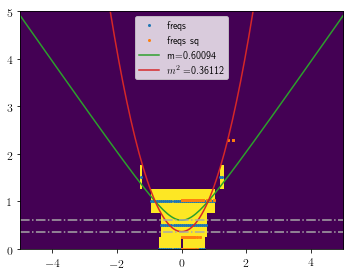

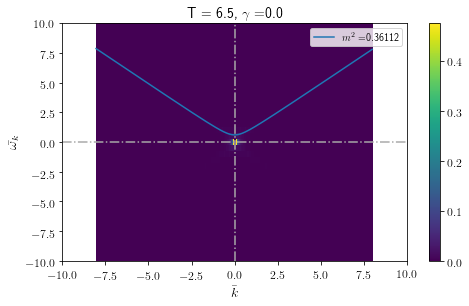

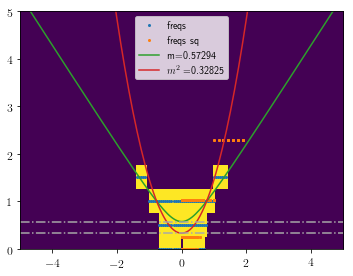

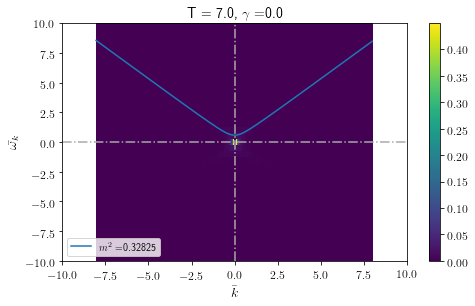

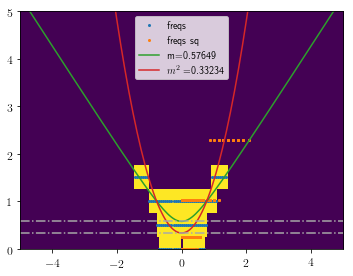

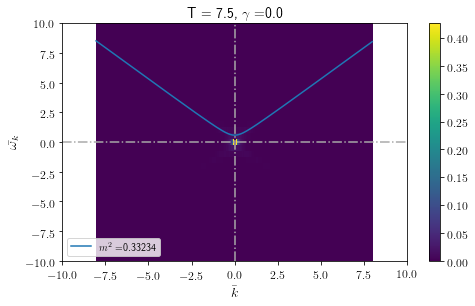

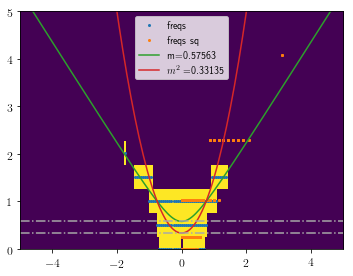

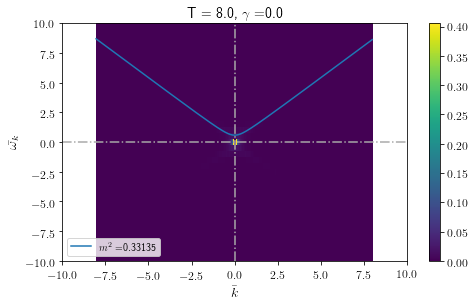

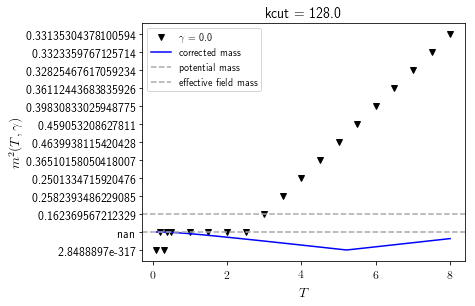

In [23]:
list_gamma_prov = list_gamma[1:2]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

kcut = kcut_list[0]; print(kcut)
for gam in range(len(list_gamma_prov[:])):
    col = next(colors)
    masses = get_masses(kcut, gam+1)

    #mean_masses = np.ndarray.flatten(np.nanmean(masses, axis=1))
    th_masses = np.asarray([-m2eff + deltam2(phi0, lamb, m2eff, tem, 0.) for tem in fine_temp_list])
    # so mu2 is the corrected mass due to SSB and to this we add the lattice correction dependent on bare mass
    th_masses_bare = np.asarray([mu2 + deltam2(phi0, lamb, m2eff, tem, 0.) for tem in fine_temp_list])

    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma_prov[gam]))
plt.plot(fine_temp_list, np.abs(th_masses), color=next(colors), label='corrected mass')
#plt.plot(fine_temp_list, np.abs(th_masses_bare), color=next(colors), label='corrected effective field mass')
plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.axhline(mu2, color='darkgray', ls='--', label='effective field mass')
plt.title('kcut = '+str(kcut))
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()

16.0


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


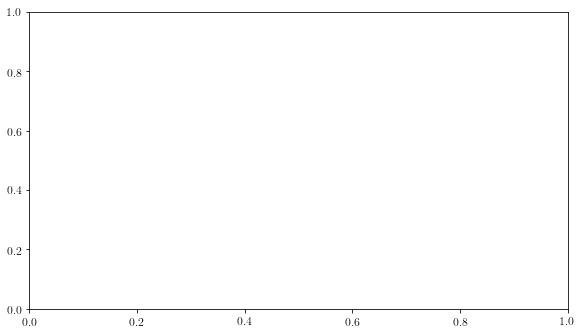

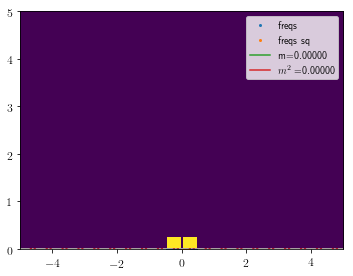

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in sqrt


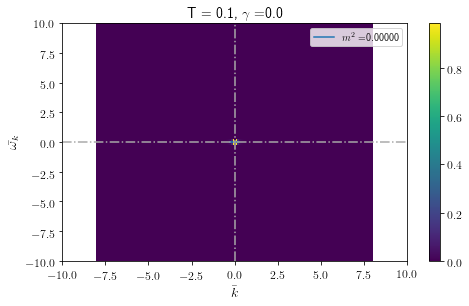

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt


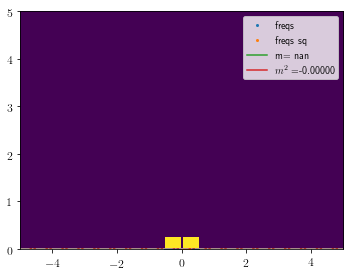

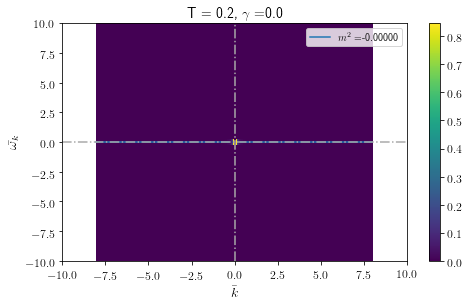

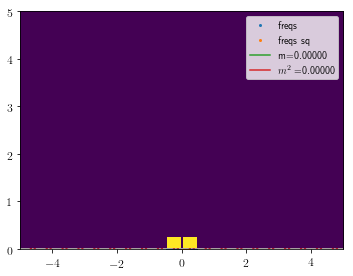

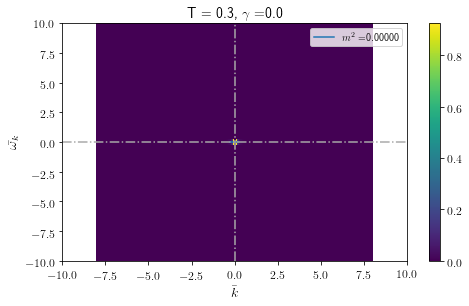

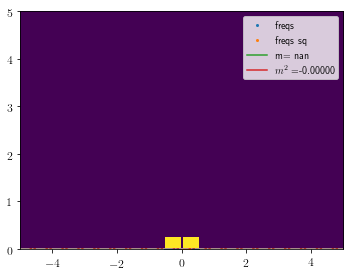

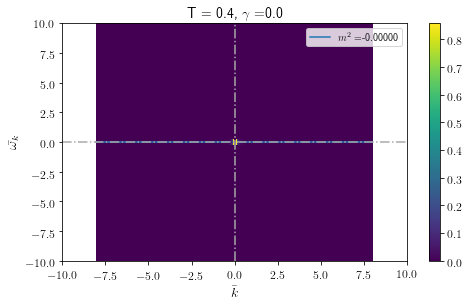

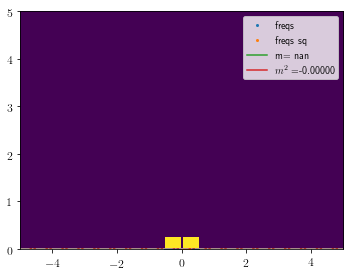

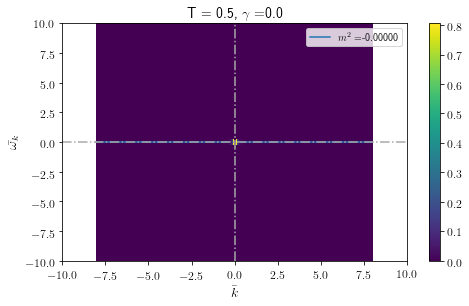

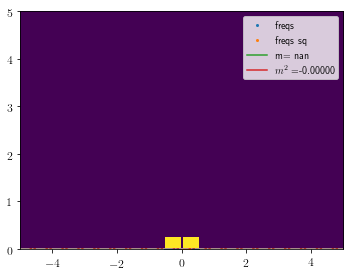

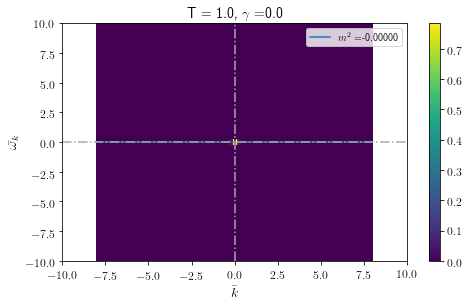

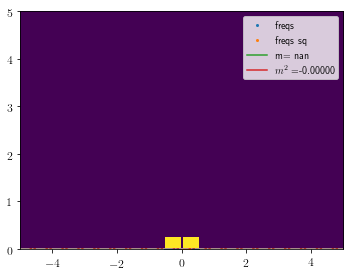

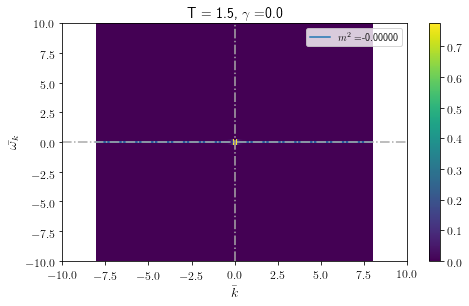

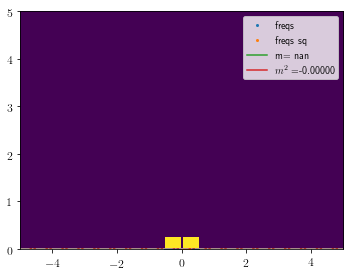

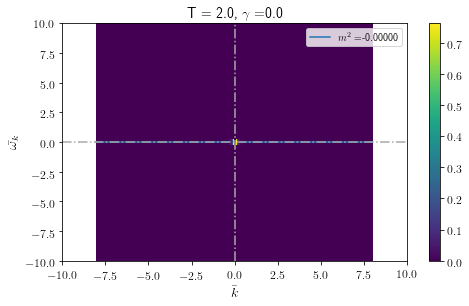

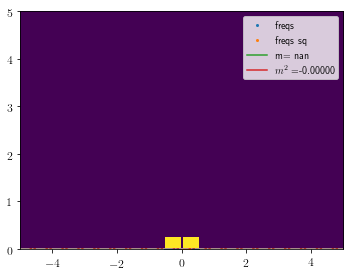

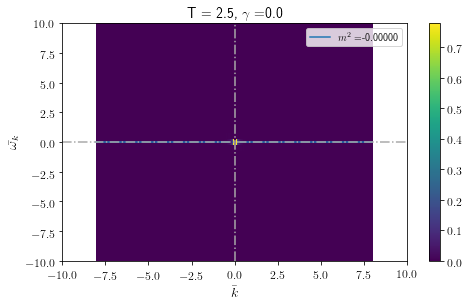

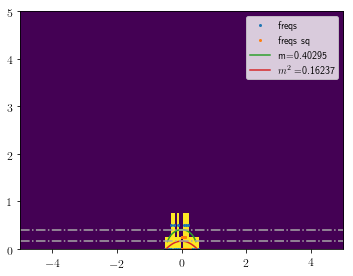

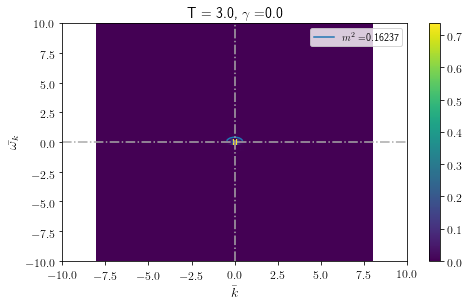

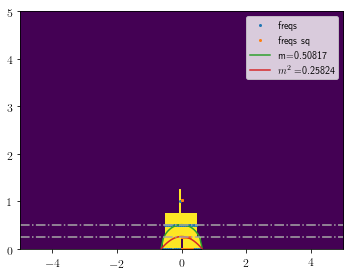

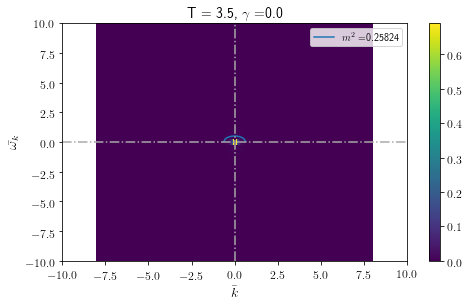

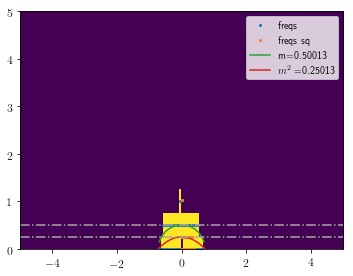

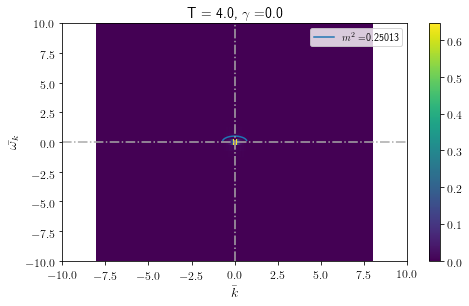

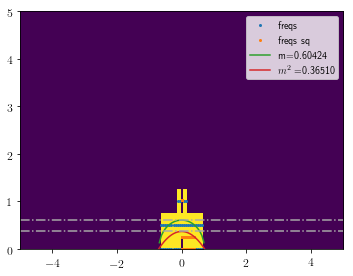

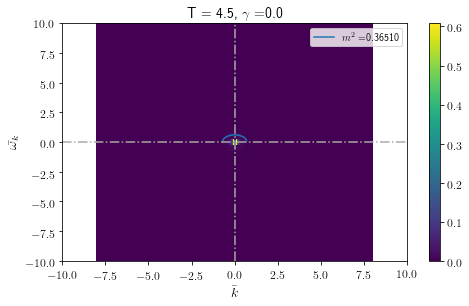

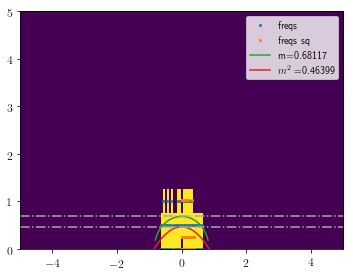

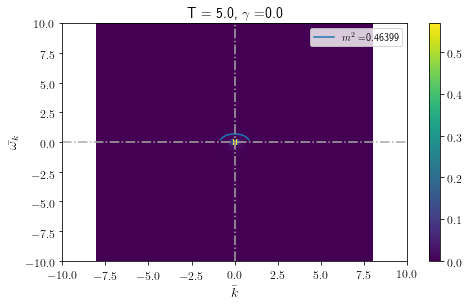

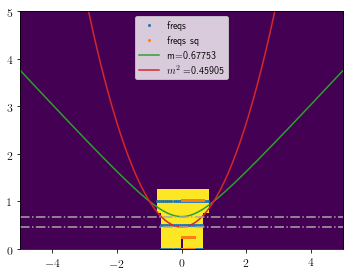

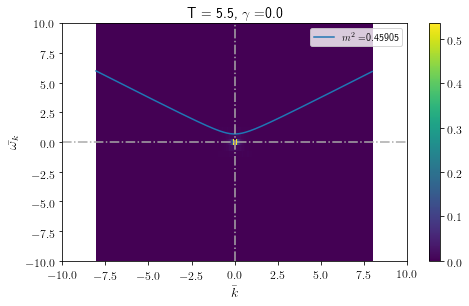

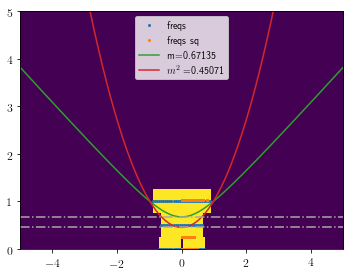

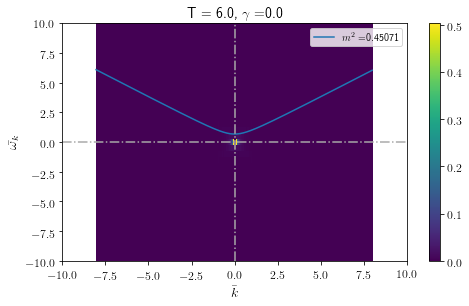

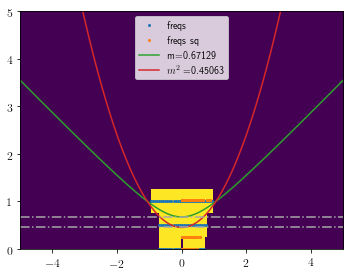

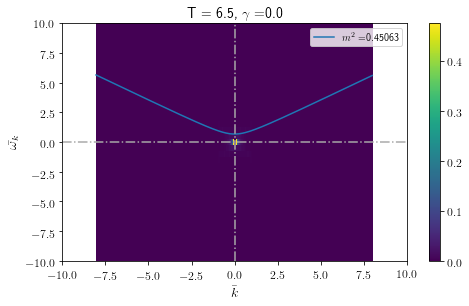

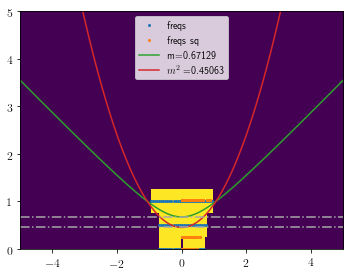

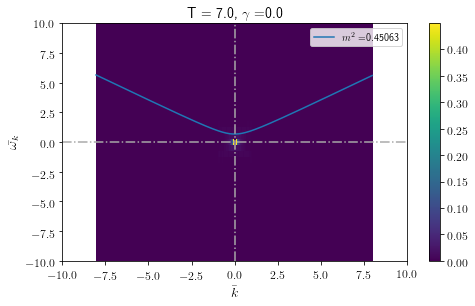

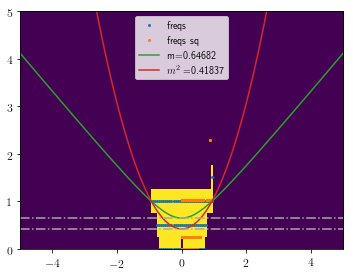

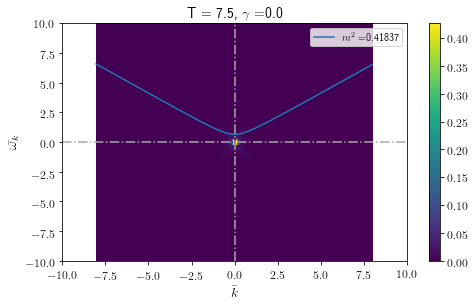

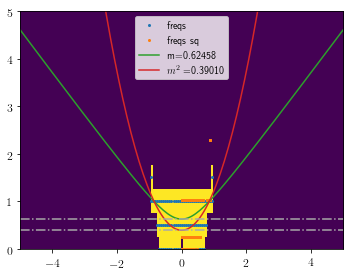

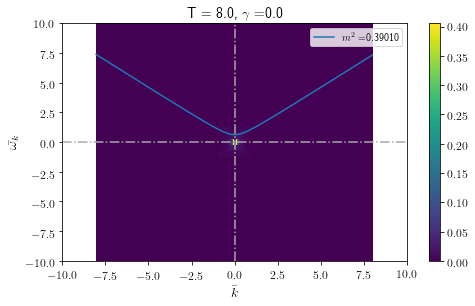

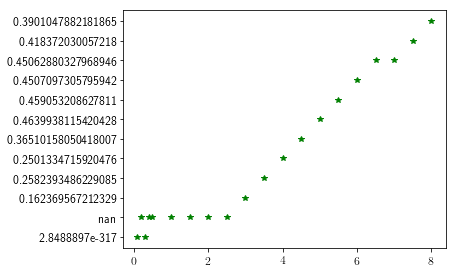

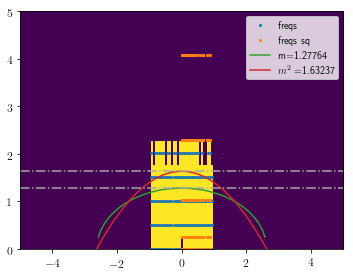

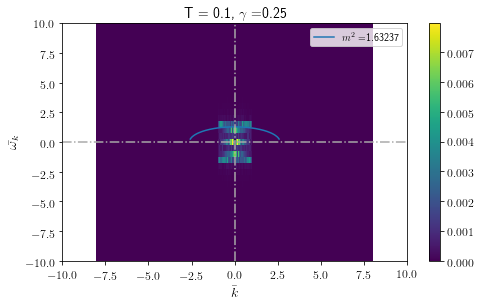

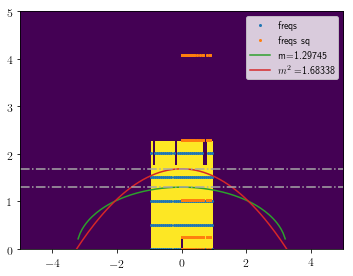

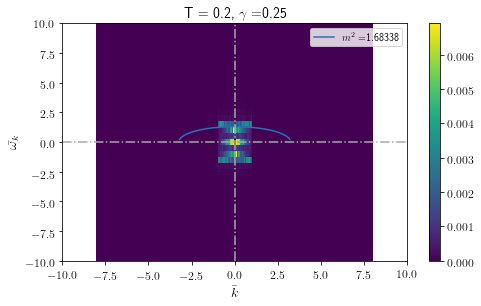

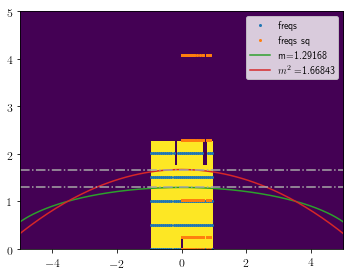

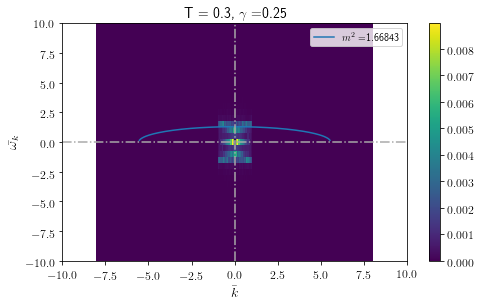

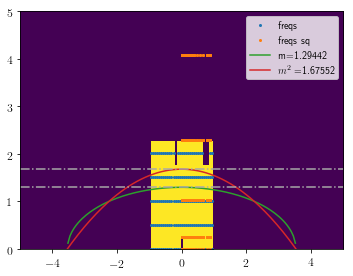

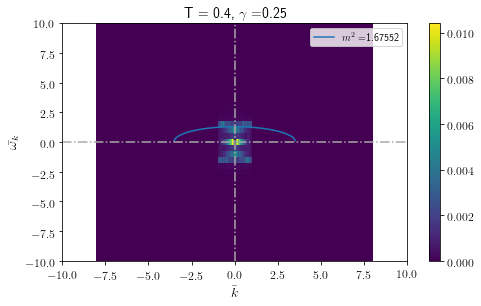

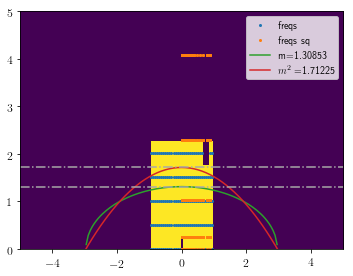

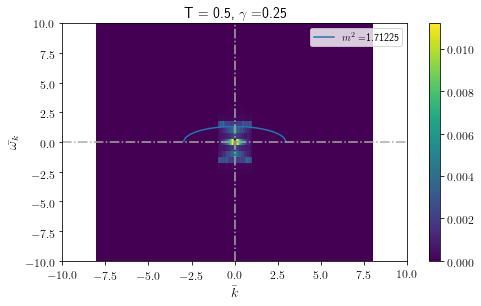

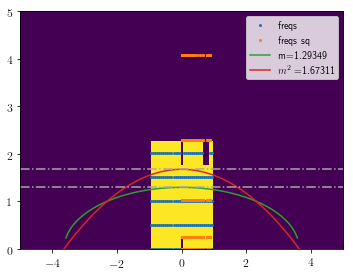

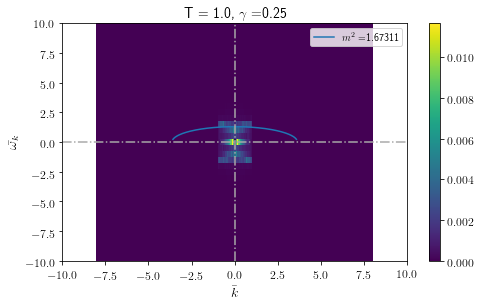

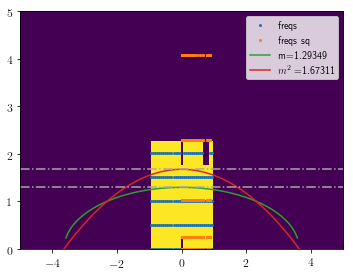

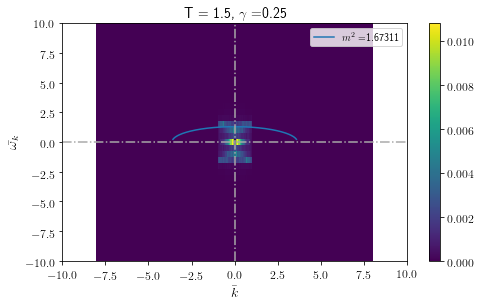

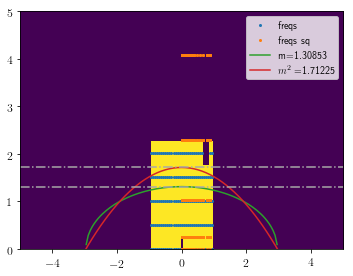

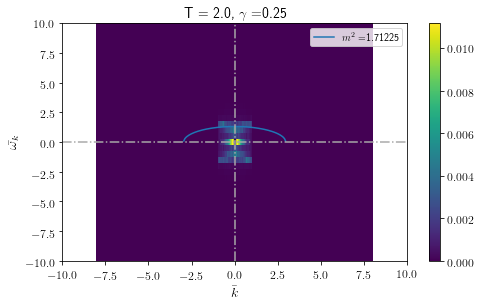

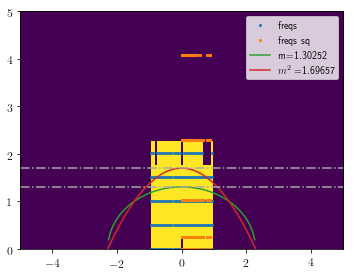

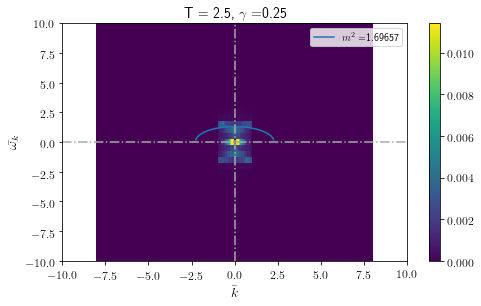

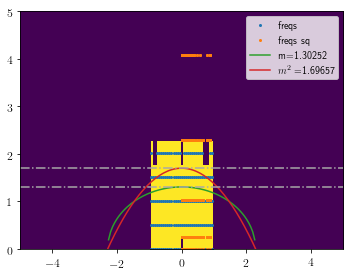

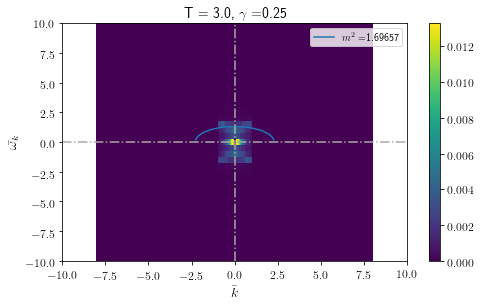

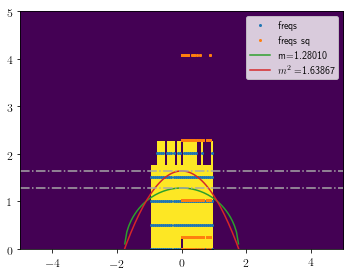

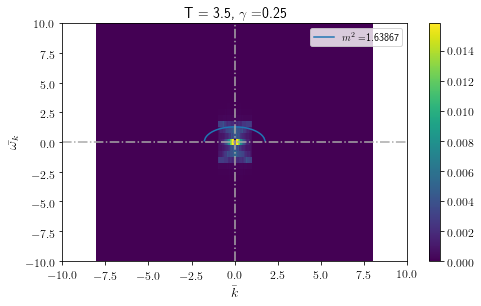

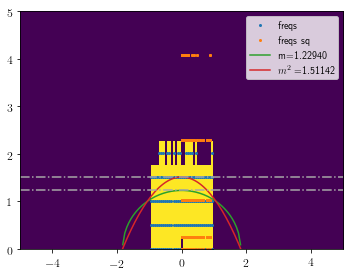

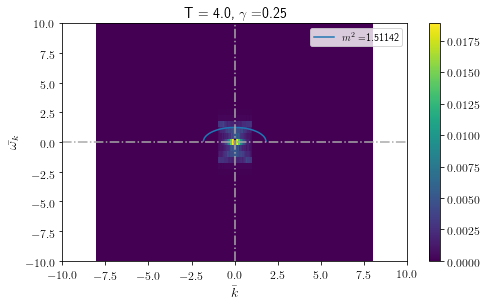

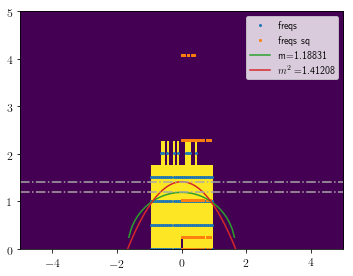

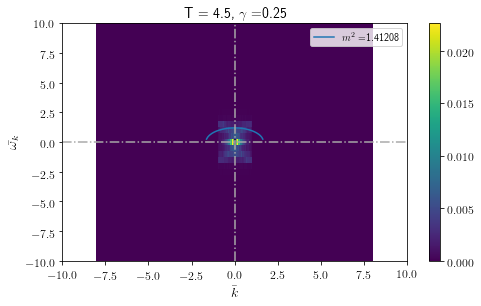

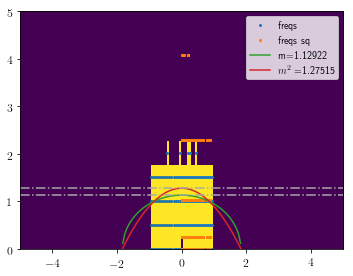

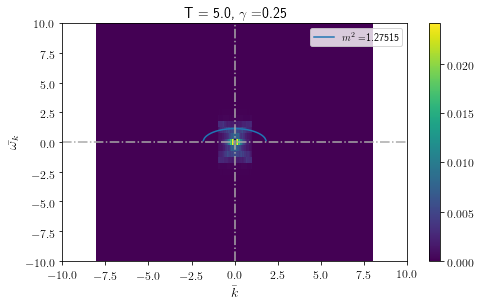

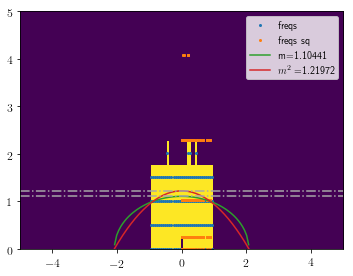

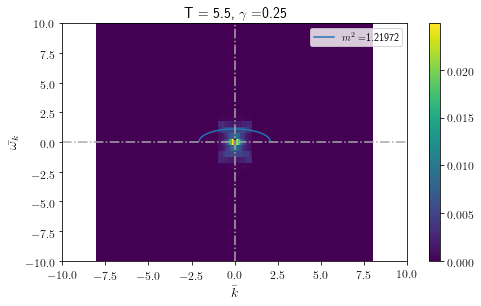

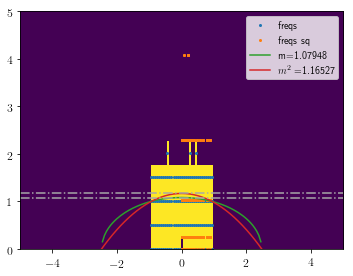

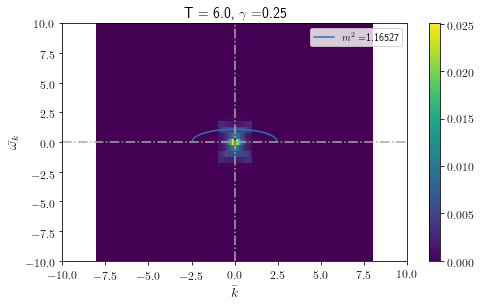

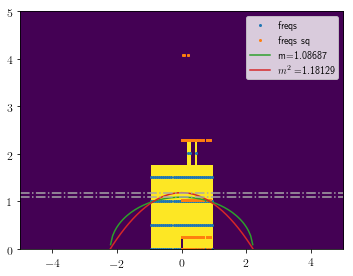

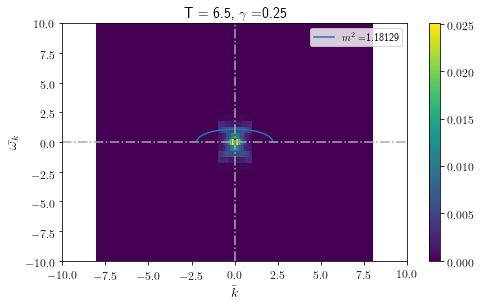

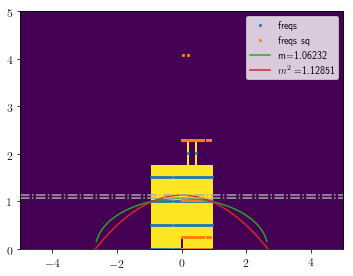

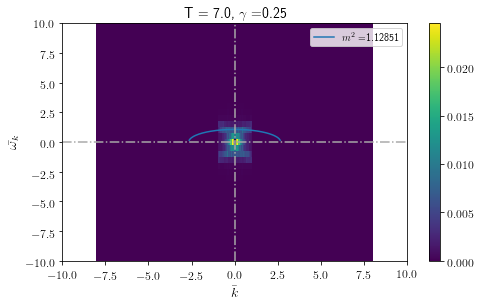

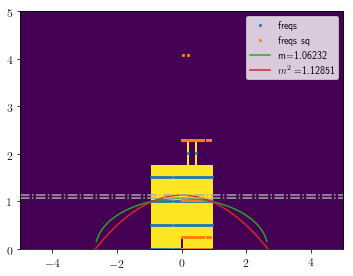

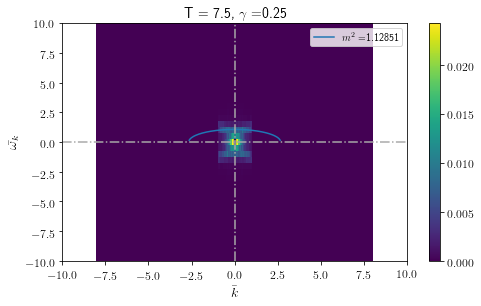

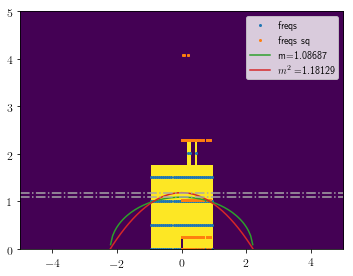

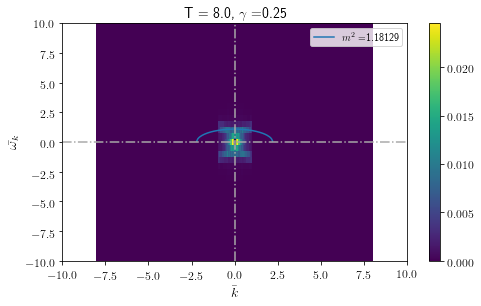

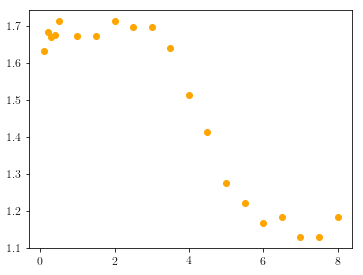

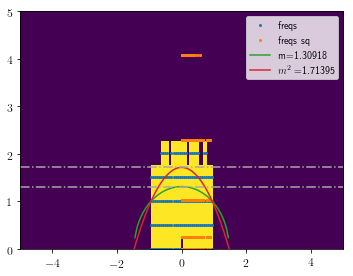

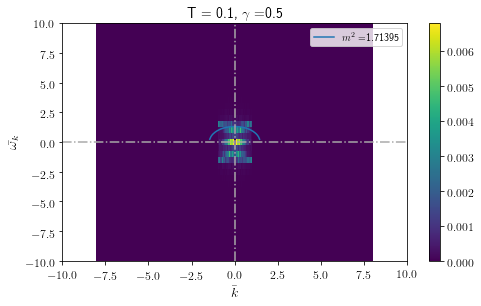

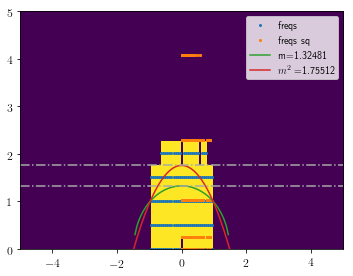

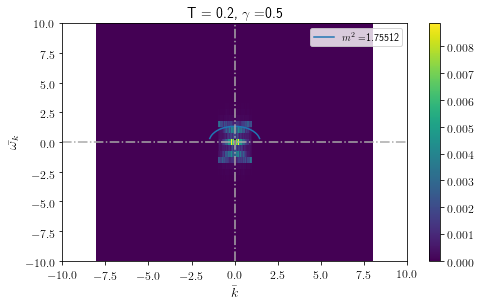

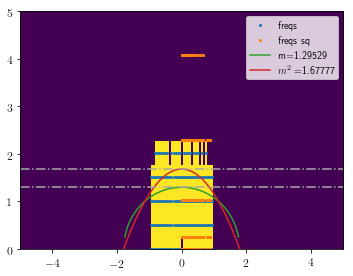

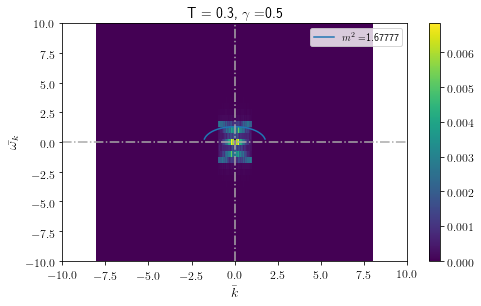

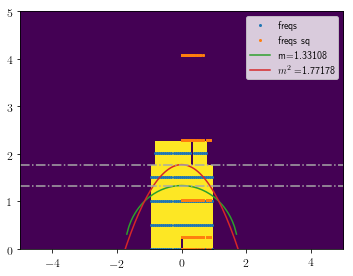

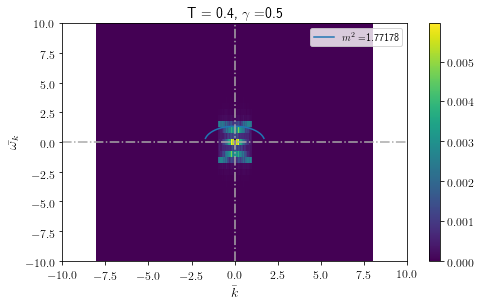

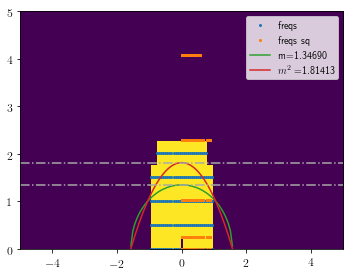

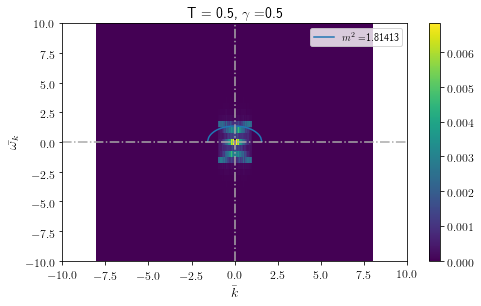

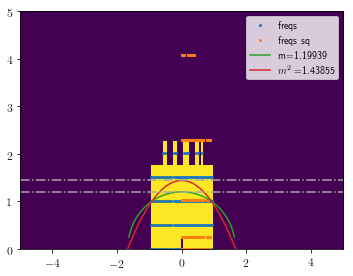

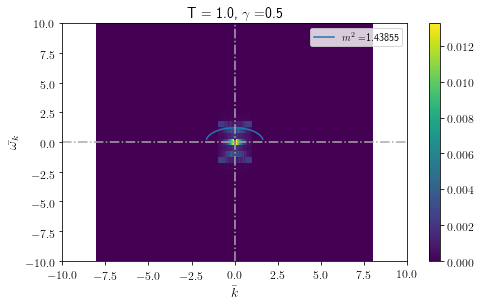

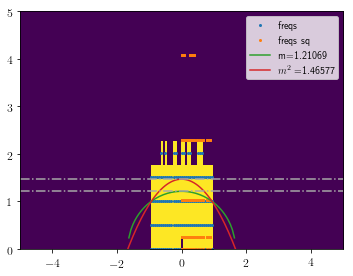

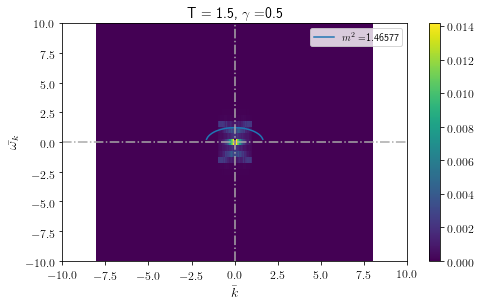

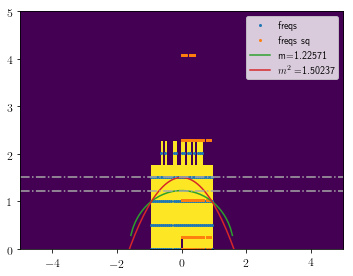

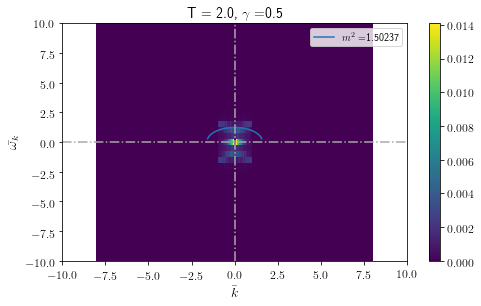

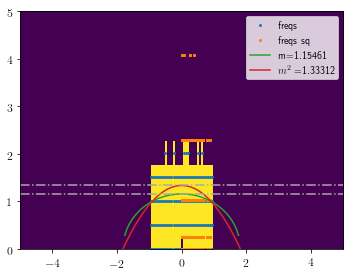

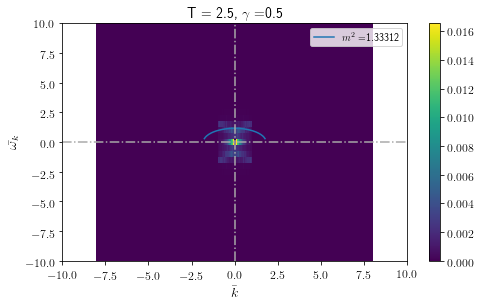

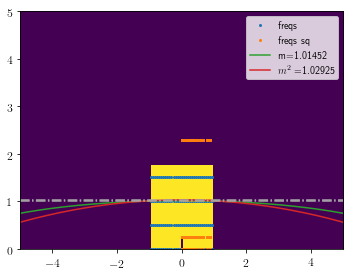

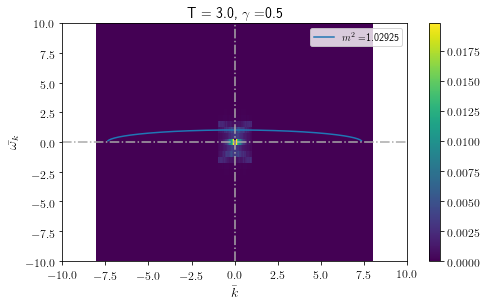

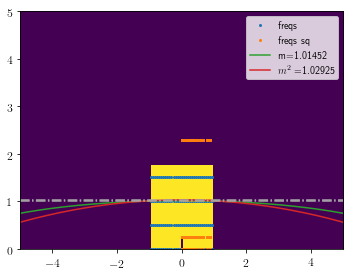

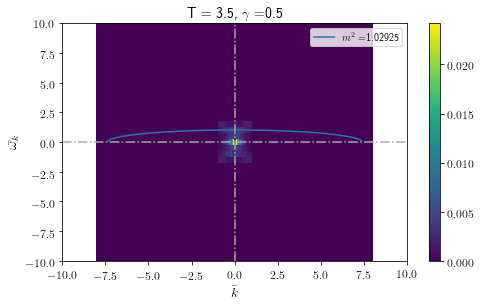

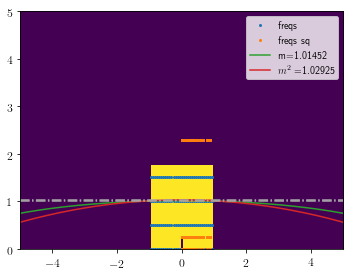

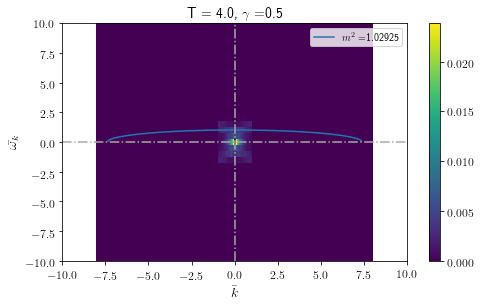

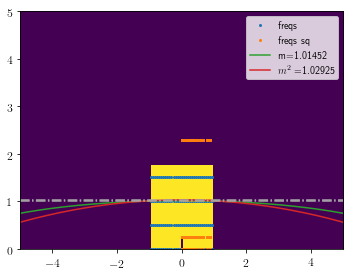

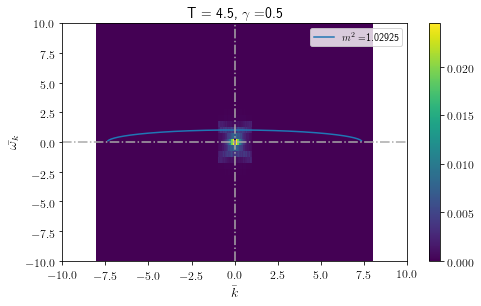

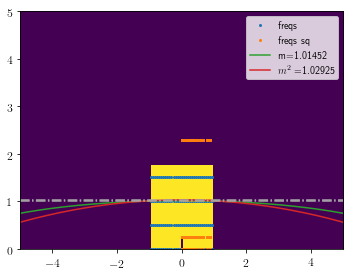

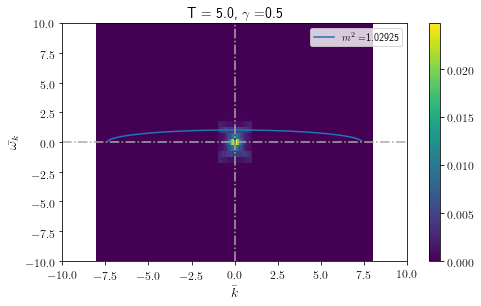

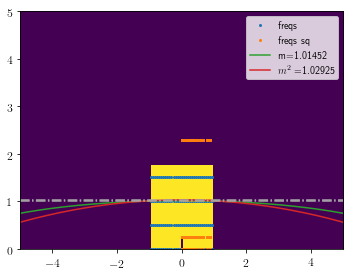

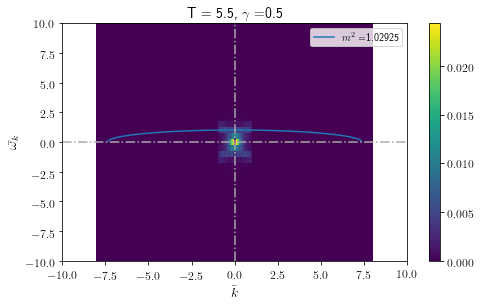

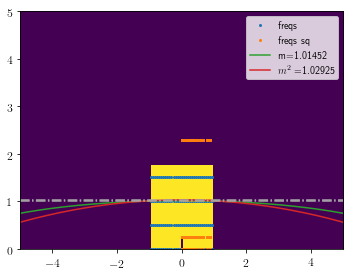

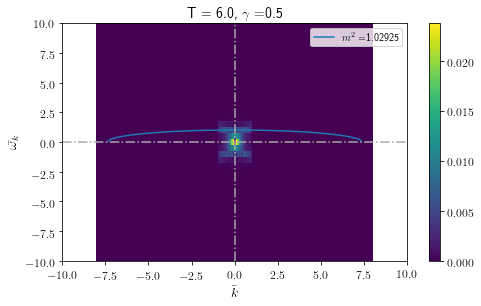

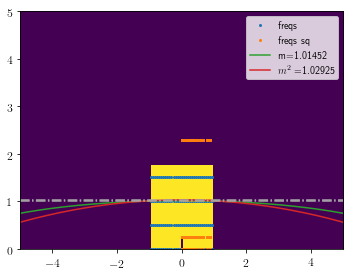

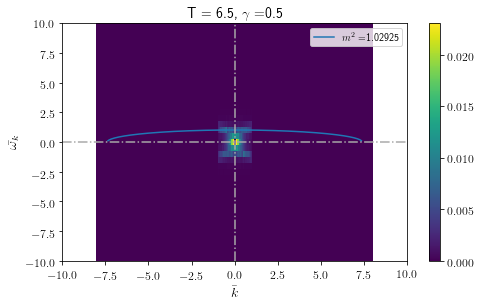

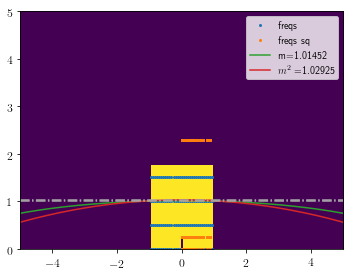

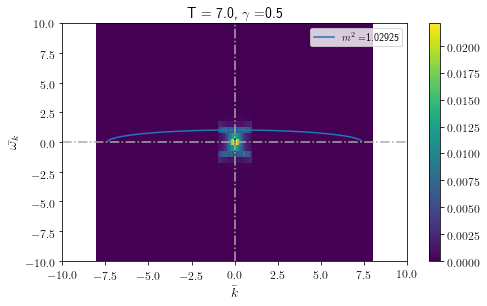

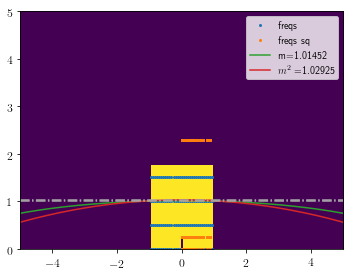

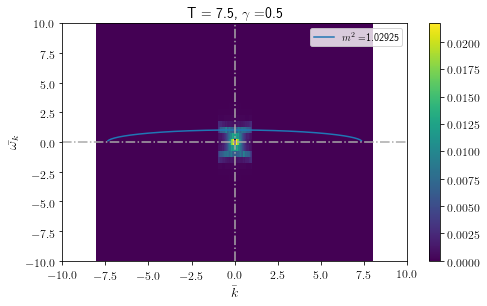

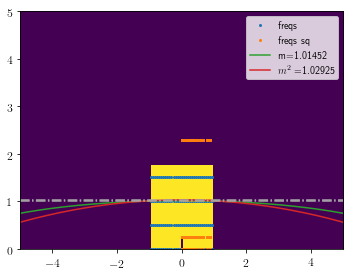

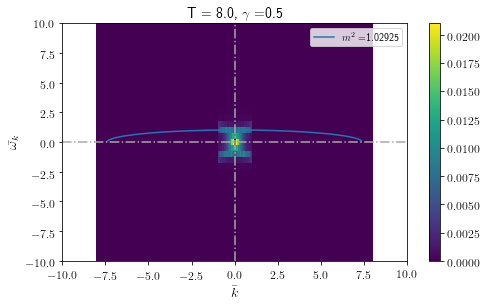

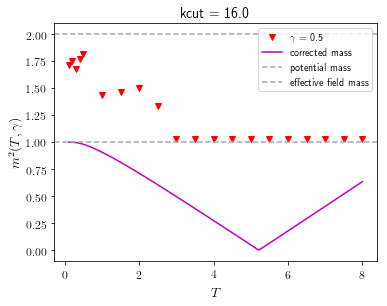

In [24]:
list_gamma_prov = list_gamma[1:]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

kcut = kcut_list[-1]; print(kcut)
for gam in range(len(list_gamma_prov[:])):
    col = next(colors)
    masses = get_masses(kcut, gam+1)

    #mean_masses = np.ndarray.flatten(np.nanmean(masses, axis=1))
    th_masses = np.asarray([-m2eff + deltam2(phi0, lamb, m2eff, tem, 0.) for tem in fine_temp_list])
    # so mu2 is the corrected mass due to SSB and to this we add the lattice correction dependent on bare mass
    th_masses_bare = np.asarray([mu2 + deltam2(phi0, lamb, m2eff, tem, 0.) for tem in fine_temp_list])

    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma_prov[gam]))
plt.plot(fine_temp_list, np.abs(th_masses), color=next(colors), label='corrected mass')
#plt.plot(fine_temp_list, np.abs(th_masses_bare), color=next(colors), label='corrected effective field mass')
plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.axhline(mu2, color='darkgray', ls='--', label='effective field mass')
plt.title('kcut = '+str(kcut))
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()